## Objetivos
Este notebook tem como objetivo apresentar o modelo SVM (ou máquina de vetores suporte) para problemas de classificação (SVC) apresentando suas características e comparando os resultados com implementações variadas.

Para isso será utilizado o *dataset* "Palmer Archipelago (Antarctica) penguin data" disponível em: https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data

Sendo o objetivo discorrer sobre um modelo específico, não haverá processo de exploração ou explanação dos dados. Além disso, toda a manipução e transformação de dados realizada será voltada apenas para demonstrar o impacto sobre a performance do modelo.

## Disposições gerais
SVM, do inglês *Support Vector Machines*, é um modelo de aprendizado de máquina que procura separar os dados através de reta, plano ou hiperplano de maneira a maximizar a distância entre a superfície de decisão e os elementos das classes. O resultado desse mecanismo é uma separação robusta entre classes. 

Para este fim, o modelo cria um espaço de dados com mais dimensões que o original e calcula uma fórmula simplificada que representa os elementos nesse novo espaço, Evitando assim mapear de forma explícita os dados, ação que acarretaria em maior custo computacional. Dessa forma, mesmo que os dados utilizados não sejam linearmente separáveis em seu espaço original, no novo espaço de dados criado pelo SVM eles serão. Esse mecanismo, que caracteriza, o modelo é conhecido como *kernel trick*, ou truque de *kernel*.

Os Vetores Suporte, que dão nome ao modelo, são os pontos da fronteira da superfície de decisão e, embora difíceis de interpretar, podem ser acessados através do método *.support_vectors_* após o treinamento do modelo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC

from sklearn import svm, datasets

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Importando o módulo com o StandardScaler
from sklearn import preprocessing

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5)

In [2]:
df = pd.read_csv("dados/penguins_lter.csv")
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [3]:
# Selecionando as variáveis (dependente e independentes) que serão utilizadas nas demonstrações
features = ['Species','Culmen Length (mm)','Culmen Depth (mm)',
            'Flipper Length (mm)','Body Mass (g)']

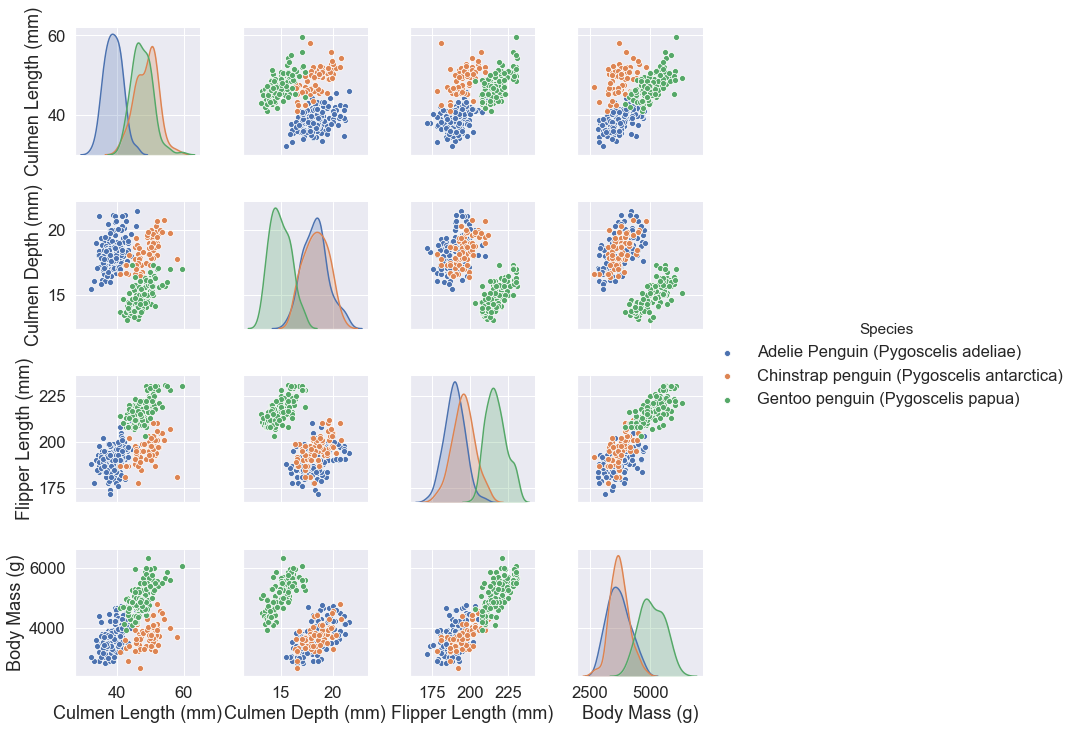

In [4]:
sns.pairplot(data=df[features],hue='Species')

Como se pode observar, as *features* numéricas dessa base de dados variam entre linearmente separáveis e não separáveis. Os modelos SVM possuem implementações para resolver ambos os casos.

## Funções para cálculo das métricas

In [5]:
def desempenho(modelo,treino_X,treino_y,teste_y,predicted):
    scor = round(modelo.score(treino_X,treino_y)*100,2)
    acc = round(accuracy_score(predicted,teste_y)*100,2)
    
    return {'score':scor,'accuracy':acc}

def fitting(modelo,treino_x,treino_y):
    return modelo.fit(treino_x,treino_y)

## Funções para exibir as superfícies de decisão

In [6]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max =y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_plot(model_fit,title,x_label,y_label):
    '''model_fit: modelo já com os dados adequados'''
    fig, ax = plt.subplots()
    X0, X1 = X.values[:, 0], X.values[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    clf = model_fit
    
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.Spectral, s=20, edgecolors='k')
    ax.set_ylabel(x_label,size=15)
    ax.set_xlabel(y_label,size=15)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

## 1. Pré-processamento

Como citado anteriormente, o SVM utiliza cálculo de distâncias para construção da superfície de decisão portanto suas implementações são sensíveis às diferentes escalas das *features*. Observe os valores das variáveis abaixo. Temos, por exemplo, "Culmen Depth (mm)" e "Body Mass (g)". A primeira está medida em dezenas e a segunda em milhares, dessa forma o algoritmo irá atribuir mais importância à segunda, mesmo que nada indique que esta tenha maior correlação com a variável dependente "Species".

Veremos, no exemplo a seguir, o impacto no desempenho do modelo causado pela falta de padroinzação .

### 1.1. Sem padronização

In [7]:
# Selecionando apenas as features numéricas e removendo os valores faltantes nessa seleção.
df_01 = df[features].dropna()
df_01.head()

,Species,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g)
0,Adelie Penguin (Pygoscelis adeliae),39.1,18.7,181.0,3750.0
1,Adelie Penguin (Pygoscelis adeliae),39.5,17.4,186.0,3800.0
2,Adelie Penguin (Pygoscelis adeliae),40.3,18.0,195.0,3250.0
4,Adelie Penguin (Pygoscelis adeliae),36.7,19.3,193.0,3450.0
5,Adelie Penguin (Pygoscelis adeliae),39.3,20.6,190.0,3650.0


In [8]:
# Repartindo entre treinamento e teste
X = df_01.drop("Species", axis=1)
y = df_01["Species"]

SEED = 144
np.random.seed(SEED)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.20)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(273, 4) (69, 4) (273,) (69,)


In [9]:
# Instanciando o modelo SVM com os hiperparâmetros padrão e random_state definido.
svc_01_nao_padronizado = SVC(C=1.0, kernel='rbf', gamma='auto', random_state=144)

In [10]:
# adequando os dados ao modelo 1
fitting(svc_01_nao_padronizado,train_X,train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=144, shrinking=True, tol=0.001,
    verbose=False)

In [11]:
# Classificando
svc_01_pred = svc_01_nao_padronizado.predict(test_X)

In [12]:
# Obtendo o score e a acurácia
resultados_01 = desempenho(svc_01_nao_padronizado,train_X,train_y,test_y,svc_01_pred)
resultados_01

{'score': 99.63, 'accuracy': 63.77}

### 1.2. Com padronização

In [13]:
df_02 = df_01.copy()
df_02.head()

,Species,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g)
0,Adelie Penguin (Pygoscelis adeliae),39.1,18.7,181.0,3750.0
1,Adelie Penguin (Pygoscelis adeliae),39.5,17.4,186.0,3800.0
2,Adelie Penguin (Pygoscelis adeliae),40.3,18.0,195.0,3250.0
4,Adelie Penguin (Pygoscelis adeliae),36.7,19.3,193.0,3450.0
5,Adelie Penguin (Pygoscelis adeliae),39.3,20.6,190.0,3650.0


In [14]:
# instanciando o scaler
std_2 = preprocessing.StandardScaler(with_mean=True, with_std=True)

In [15]:
# Transformando os dados e visualizando
df_02[features[1:]] = std_2.fit_transform(df_02[features[1:]])
df_02.head()

,Species,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g)
0,Adelie Penguin (Pygoscelis adeliae),-0.884499,0.785449,-1.418347,-0.564142
1,Adelie Penguin (Pygoscelis adeliae),-0.811126,0.126188,-1.062250,-0.501703
2,Adelie Penguin (Pygoscelis adeliae),-0.664380,0.430462,-0.421277,-1.188532
4,Adelie Penguin (Pygoscelis adeliae),-1.324737,1.089724,-0.563715,-0.938776
5,Adelie Penguin (Pygoscelis adeliae),-0.847812,1.748985,-0.777373,-0.689020


In [16]:
# Repartindo entre treinamento e teste
X = df_02.drop("Species", axis=1)
y = df_02["Species"]

SEED = 144
np.random.seed(SEED)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.20)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(273, 4) (69, 4) (273,) (69,)


In [17]:
# Instanciando um novo modelo SVM com os mesmos hiperparâmetros e random_state
svc_02_padronizado = SVC(C=1.0, kernel='rbf', gamma='auto', random_state=144)

In [18]:
# adequando os dados ao modelo 2, fazendo predições e obtendo os resultados de treinamento e accuracy score.

fitting(svc_02_padronizado,train_X,train_y)
svc_02_pred = svc_02_padronizado.predict(test_X)
resultados_02 = desempenho(svc_02_padronizado,train_X,train_y,test_y,svc_02_pred)
resultados_02

{'score': 98.17, 'accuracy': 98.55}

## 1.3. Comparando os resultados

In [19]:
print(f'Resultados sem padronização: {resultados_01}\nResultados com padronização (std-scaler): {resultados_02}')
ganho_percent = 100*(resultados_02['accuracy']-resultados_01['accuracy'])/resultados_01['accuracy']
print(f'\nOcorreu um aumento de {ganho_percent:0.2f}% na acurácia do modelo')

Resultados sem padronização: {'score': 99.63, 'accuracy': 63.77}
Resultados com padronização (std-scaler): {'score': 98.17, 'accuracy': 98.55}

Ocorreu um aumento de 54.54% na acurácia do modelo


Mantendo os mesmos parâmetros do modelo, a diferença de acurácia nos dados de treinamento (*accuracy score*) foi bastante significativa. Um salto de 63,77% para 98,55%. Observe também que a acurácia obtida na segunda implementação foi alta, o que pode indicar relativa facilidade na tarefa de classificação deste *dataset*. Os modelos de SVM são poderosos, portanto podem obter altos desempenhos como este quando aplicados a problemas relativamente simples.

## 1.4. Observação: StandardScaler

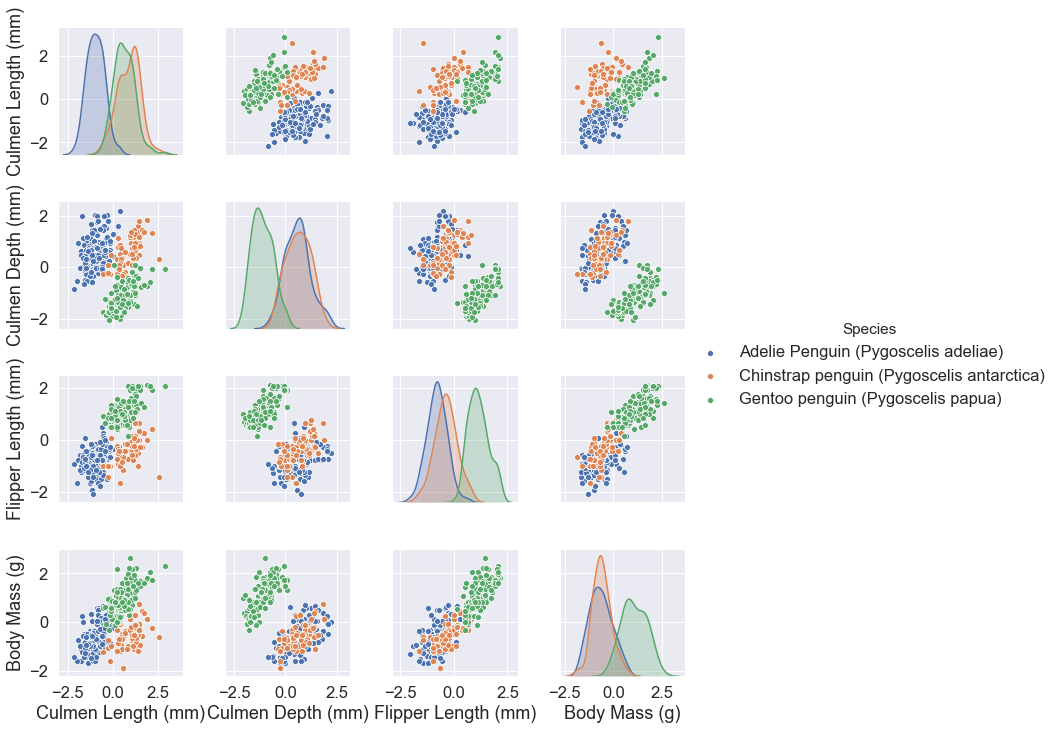

In [20]:
sns.pairplot(data=df_02[features],hue='Species')

Comparando os gráficos de pares exibidos acima, observa-se o resultado prático da aplicação do *StandardScaler*. A distribuição dos dados no espaço permanece a mesma, porém esses encontram-se agora normalizados em valores que vão de -2 a 2. Nessa aplicação os argumentos foram os padrões para o método, portanto as médias e os desvios-padrão utilizados foram calculados das próprias amostras. Caso os argumentos *with_mean* e *with_std* fossem passados como "False", o método utilizaria média 0 e desvio-padrão 1 para todas as amostras.

## 2. Hiperparâmetros

O modelo SVC permite diversas opções para *tuning*, abaixo são listados alguns dos hiperparâmetros e seus valores padrão.

- **C = 1.0**: Parâmetro de penalização do termo de erro do modelo. Na prática esse termo representa uma barganha entre precisão na classificação e suavidade da superfície de decisão. Quanto mais alto o C, mais o modelo irá ajustar a superfície de decisão aos dados de treinamento, podendo dessa forma levar o modelo ao *overfitting* (superadequação).

- **gamma** = "auto": Parâmetro que dita a formação do hiperplano. Quanto maior o valor do gamma, maior será a adequação do hiperplano aos dados de treinamento, portanto pode levar o modelo ao *overfitting*. Esse parâmetro recebe "auto", "scale" ou um número. Na opção "auto" o valor é calculado como: (1 / número de *features*).

- **kernel** = "rbf": O *kernel* define o tipo de hiperplano a ser utilizado para a separação dos dasos. O parâmetro dita o *kernel* dentre as seguintes as opções: "linear", "poly", "rbf", "sigmoid", "precomputed" ou uma função arbitrária. Como o nome sugere, o *kernel* linear representa uma reta em um espaço 2D, os demais são não-lineares. Ao utilizar o *kernel* como "poly" pode-se também definir o hiperparâmetro "**degree**" que indica o grau do polinômio estimado, sendo seu falor padrão igual a 3.

- **cache_size** = 200: Define o tamanho do *cache* (em MB) que o modelo poderá utilizar. Em aplicações com grandes bases de dados esse parâmetro, se adequado à aplicação, pode reduzir consideravelmente o tempo de treinamento do modelo.

Abaixo iremos selecionar duas *features* da nossa base de dados para que se possa observar a influência dos parâmetros discutidos acima.

In [21]:
# Criando um dicionário para mapear as categorias em "Species" para o tipo int
dcit_species = {"Adelie Penguin (Pygoscelis adeliae)":1,
                "Chinstrap penguin (Pygoscelis antarctica)":2,
                "Gentoo penguin (Pygoscelis papua)":3}

# Repartindo entre treinamento e teste
X = df_02.drop(["Species","Flipper Length (mm)","Body Mass (g)"], axis=1)
y = df_02["Species"]

y = y.replace(dcit_species).astype(np.int32)

SEED = 144
np.random.seed(SEED)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.20)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(273, 2) (69, 2) (273,) (69,)


## 2.1. Variação do C

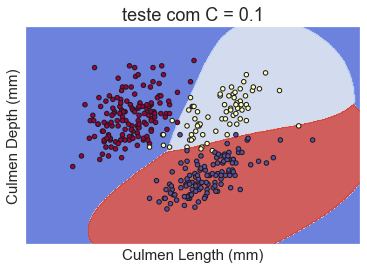

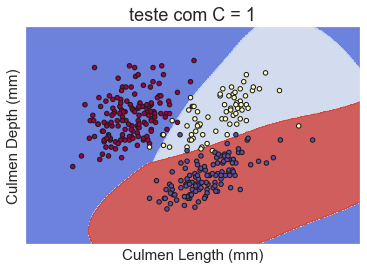

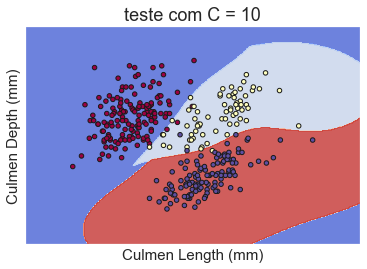

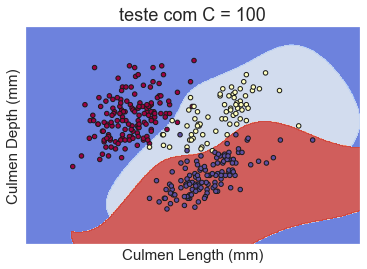

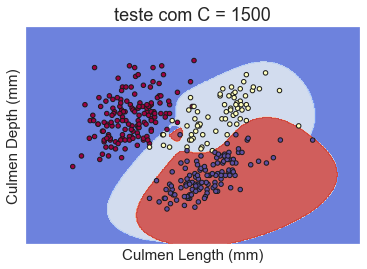

In [22]:
# Exibindo as superfícies de decisão com o hiperparÂmetro C variando de 0,1 a 1500
c_list = [0.1, 1, 10, 100, 1500]
y_label, x_label = X.columns

for c in c_list:
    modelo = SVC(C=c, kernel='rbf', gamma='auto', random_state=144)
    fitted = modelo.fit(X,y)
    
    titulo = f'teste com C = {c}'
    plot_plot(fitted,titulo,x_label,y_label)

Observe que na medida em que cresce o parâmetro "C", as fronteiras das superfícies de decisão tornam-se mais curvilíneas, ganham reentrâncias. Com C = 1500 a superfície de decisão em vermelho ganha um segmento, no centro da visualização, separado do restante. Nota-se que esse segmento surgiu para classificar apenas um elemento. Assim como próximo a este, a superfície azul também encontra um caminho até dois pontos que anteriormente estavam sob a superfície branca. 

Os dois pontos citados acima demonstram um caso claro de *overfitting*, ou seja, o modelo se adequa quase que perfeitamente aos dados de treinamento, gerando dificuldades na classificação de novos dados.

## 2.2. Variação do gamma

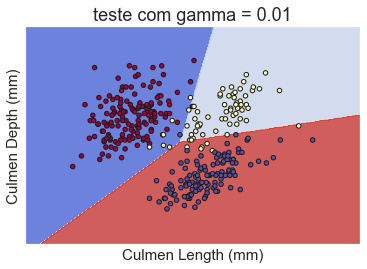

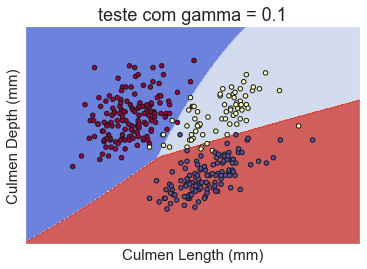

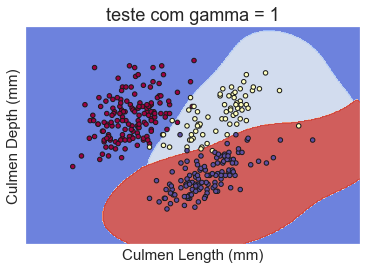

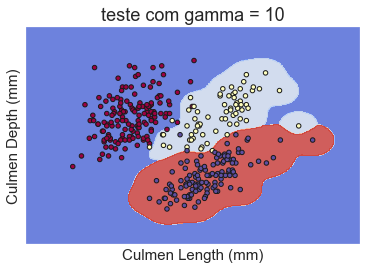

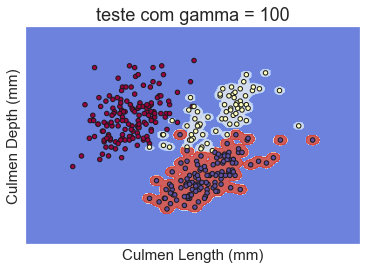

In [23]:
# Exibindo as superfícies de decisão com o hiperparÂmetro C variando de 0,1 a 1500
gamma_list = [0.01,0.1, 1, 10, 100]
y_label, x_label = X.columns

for gamma in gamma_list:
    modelo = SVC(C=1.0, kernel='rbf', gamma=gamma, random_state=144)
    fitted = modelo.fit(X,y)
    
    titulo = f'teste com gamma = {gamma}'
    plot_plot(fitted,titulo,x_label,y_label)

O parâmetro "gamma", ao crescer, aumenta a adequação do hiperplano criado pelo modelo aos dados de treianmento. O resultado de um alto "gamma" também é *overfitting*, como se pode observar nas visualizações acima. A superfície de decisão se ajusta aos elementos até o ponto em que cada elemento individual será devidamente classificado.

## 2.3 Variação do kernel

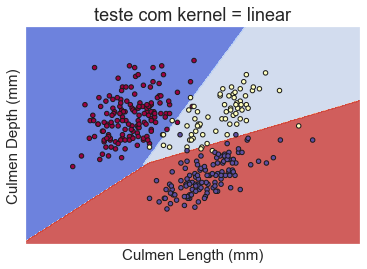

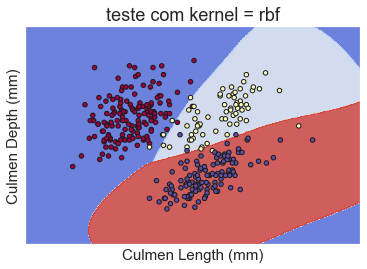

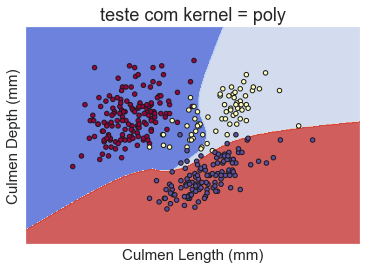

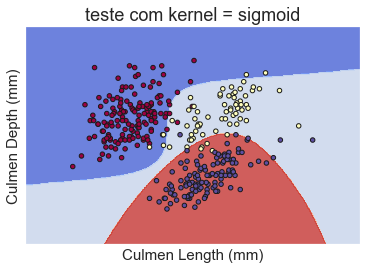

In [24]:
# Exibindo as superfícies de decisão com o hiperparÂmetro C variando de 0,1 a 1500
kernel_list = ["linear","rbf","poly","sigmoid"]

for kernel in kernel_list:
    modelo = svm.SVC(kernel=kernel ,C=1.0, gamma = 'auto')
    fitted = modelo.fit(X, y)
    
    titulo = f'teste com kernel = {kernel}'
    plot_plot(fitted,titulo,x_label,y_label)

Com as mudanças de *kernel* pode-se observar diferenças significativas nas superfícies de decisão, essas mudanças decorrem da matemática por trás de cada kernel. Para que o modelo tenha eficácia, a escolha do *kernel* deve ser realizada de acordo com cada problema a ser resolvido.

### Referências
- livro Machine Learning guia de referência rápida
- Curso IFCE/Huawei para certificação HCIA-AI 2021.1
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### Código para exibir as superfícies de decisão
- https://towardsdatascience.com/support-vector-machines-svm-clearly-explained-a-python-tutorial-for-classification-problems-29c539f3ad8

Notebook criado por Luan Luna Coelho Gomes.

entre em contato:
- luan144@gmail.com
- https://www.linkedin.com/in/luan-luna/